In [1]:
# TensorFlow and tf.keras
import json
import random
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 import

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

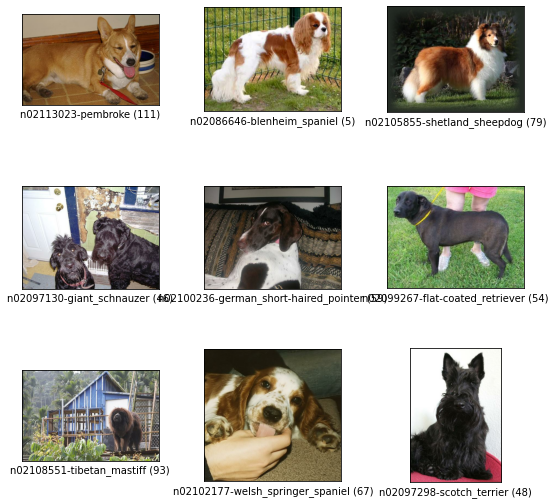

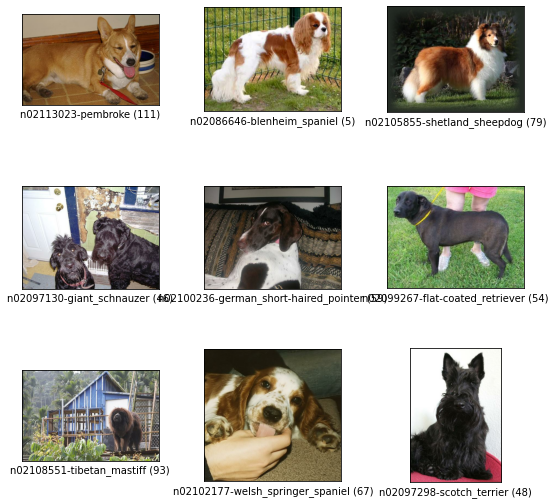

In [4]:
tfds.show_examples(ds_train, ds_info)

# 주요 함수

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [7]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [8]:
def augment2(image,label):
    choice = [random.random() for value in range(8)]

    augmentations = [
        lambda img: tf.image.random_brightness(img, max_delta=0.2),
        lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2),
        lambda img: tf.image.central_crop(img, central_fraction=random.uniform(0.7, 1.0)),
        lambda img: tf.image.random_flip_left_right(img),
        lambda img: tf.image.random_flip_up_down(img),
        lambda img: tf.image.random_hue(img, max_delta=0.2),
        lambda img: tf.image.random_jpeg_quality(img, min_jpeg_quality=70, max_jpeg_quality=100),
        lambda img: tf.image.random_saturation(img, lower=0.8, upper=1.2),
    ]
    
    for apply, augment in zip(choice, augmentations):
        if apply:
            image = augment(image)
            
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [11]:
# mix two labels
def mix_2_labels(label_a, label_b, mixed_img, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = mixed_img.shape[1]
    image_size_y = mixed_img.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, image_a, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [13]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [14]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds_aug = ds.map(
            augment2
        )
        ds = ds.concatenate(ds_aug)
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds_mixup = ds.map(
            mixup,
            num_parallel_calls=2
        )
        ds = ds.concatenate(ds_mixup)
    if not is_test and with_cutmix:
        ds_cutmix = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        ds = ds.concatenate(ds_cutmix)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
def apply_normalize_on_dataset_nol(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

## 모델 구축

In [18]:
num_classes = ds_info.features["label"].num_classes

### Classic resnet

In [19]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


### Aug resnet

In [20]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### Cutmix resnet

In [21]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### Mixup resnet

In [22]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 데이터 준비

In [23]:
BATCH_SIZE = 16

### 합쳐진 데이터

In [24]:
ds_train_classic = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [25]:
ds_train_augmentation = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)

In [26]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)

In [38]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)

In [39]:
ds_test_all = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

### 합치지 않은 데이터

In [ ]:
ds_train_nolaug = apply_normalize_on_dataset_nol(ds_train, batch_size=BATCH_SIZE, with_aug=True)

In [ ]:
ds_train_nolcutmix = apply_normalize_on_dataset_nol(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)

In [ ]:
ds_train_nolmixup = apply_normalize_on_dataset_nol(ds_train, batch_size=BATCH_SIZE, with_mixup=True)

# 실험 Log

## 과대적합 찾기

### epoch = 5, learning rate = 0.01

In [27]:
EPOCH = 5

In [28]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_classic,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 164s 203ms/step - loss: 2.2152 - accuracy: 0.4451 - val_loss: 3.3659 - val_accuracy: 0.2176
Epoch 2/5
750/750 [==============================] - 151s 201ms/step - loss: 0.7762 - accuracy: 0.7809 - val_loss: 1.0472 - val_accuracy: 0.6932
Epoch 3/5
750/750 [==============================] - 151s 201ms/step - loss: 0.3018 - accuracy: 0.9268 - val_loss: 1.0386 - val_accuracy: 0.7021
Epoch 4/5
750/750 [==============================] - 151s 201ms/step - loss: 0.0930 - accuracy: 0.9872 - val_loss: 0.8997 - val_accuracy: 0.7404
Epoch 5/5
750/750 [==============================] - 151s 201ms/step - loss: 0.0348 - accuracy: 0.9975 - val_loss: 0.9306 - val_accuracy: 0.7399


In [29]:
with open('history/history_resnet50.json', 'w') as f:
    pd.DataFrame(history_resnet50.history).to_json(f)

In [30]:
del resnet50

In [31]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_augmentation,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1500/1500 [==============================] - 265s 172ms/step - loss: 2.1315 - accuracy: 0.4455 - val_loss: 1.5198 - val_accuracy: 0.5667
Epoch 2/5
1500/1500 [==============================] - 252s 168ms/step - loss: 1.0276 - accuracy: 0.7078 - val_loss: 1.5587 - val_accuracy: 0.5681
Epoch 3/5
1500/1500 [==============================] - 267s 178ms/step - loss: 0.6295 - accuracy: 0.8227 - val_loss: 1.1708 - val_accuracy: 0.6630
Epoch 4/5
1500/1500 [==============================] - 252s 168ms/step - loss: 0.4110 - accuracy: 0.8894 - val_loss: 1.2066 - val_accuracy: 0.6688
Epoch 5/5
1500/1500 [==============================] - 252s 168ms/step - loss: 0.2891 - accuracy: 0.9249 - val_loss: 1.2568 - val_accuracy: 0.6607


In [32]:
with open('history/history_resnet50_aug.json', 'w') as f:
    pd.DataFrame(history_resnet50_aug.history).to_json(f)

In [33]:
del aug_resnet50

In [34]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1500/1500 [==============================] - 286s 186ms/step - loss: 2.4006 - accuracy: 0.4887 - val_loss: 1.1307 - val_accuracy: 0.6734
Epoch 2/5
1500/1500 [==============================] - 278s 185ms/step - loss: 1.3806 - accuracy: 0.7762 - val_loss: 1.0209 - val_accuracy: 0.7080
Epoch 3/5
1500/1500 [==============================] - 279s 186ms/step - loss: 1.1260 - accuracy: 0.8519 - val_loss: 1.1445 - val_accuracy: 0.6811
Epoch 4/5
1500/1500 [==============================] - 278s 186ms/step - loss: 1.0435 - accuracy: 0.8704 - val_loss: 1.1361 - val_accuracy: 0.6885
Epoch 5/5
1500/1500 [==============================] - 278s 185ms/step - loss: 1.0053 - accuracy: 0.8762 - val_loss: 1.1341 - val_accuracy: 0.6973


In [35]:
with open('history/history_resnet50_cutmix.json', 'w') as f:
    pd.DataFrame(history_resnet50_cutmix.history).to_json(f)

In [36]:
del cutmix_resnet50

In [37]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1500/1500 [==============================] - 285s 186ms/step - loss: 2.4158 - accuracy: 0.4851 - val_loss: 1.2864 - val_accuracy: 0.6356
Epoch 2/5
1500/1500 [==============================] - 278s 185ms/step - loss: 1.3842 - accuracy: 0.7771 - val_loss: 1.0427 - val_accuracy: 0.7004
Epoch 3/5
1500/1500 [==============================] - 278s 185ms/step - loss: 1.1326 - accuracy: 0.8501 - val_loss: 1.0717 - val_accuracy: 0.7003
Epoch 4/5
1500/1500 [==============================] - 278s 185ms/step - loss: 1.0378 - accuracy: 0.8691 - val_loss: 1.0179 - val_accuracy: 0.7239
Epoch 5/5
1500/1500 [==============================] - 278s 185ms/step - loss: 0.9978 - accuracy: 0.8802 - val_loss: 1.0414 - val_accuracy: 0.7164


In [38]:
with open('history/history_resnet50_mixup.json', 'w') as f:
    pd.DataFrame(history_resnet50_mixup.history).to_json(f)

In [39]:
del mixup_resnet50

In [40]:
with open('history/history_resnet50.json', 'r') as f:
    history_resnet50 = json.load(f)

In [39]:
with open('history/history_resnet50_aug.json', 'r') as f:
    history_resnet50_aug = json.load(f)

In [41]:
with open('history/history_resnet50_cutmix.json', 'r') as f:
    history_resnet50_cutmix = json.load(f)

In [42]:
with open('history/history_resnet50_mixup.json', 'r') as f:
    history_resnet50_mixup = json.load(f)

In [43]:
history_resnet50 = history_conv(history_resnet50)
history_resnet50_aug = history_conv(history_resnet50_aug)
history_resnet50_cutmix = history_conv(history_resnet50_cutmix)
history_resnet50_mixup = history_conv(history_resnet50_mixup)

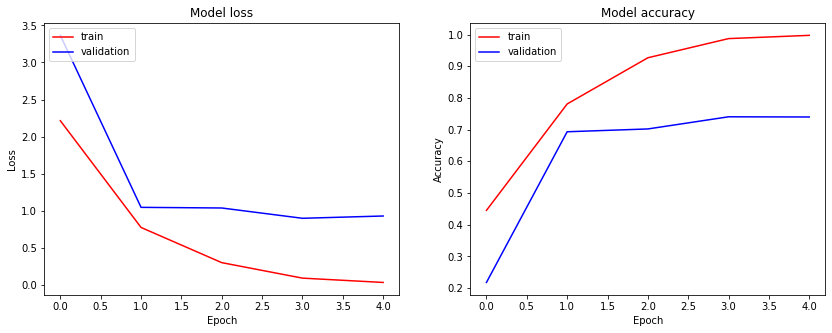

In [37]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50['loss'], 'r')
plt.plot(history_resnet50['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50['accuracy'], 'r')
plt.plot(history_resnet50['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

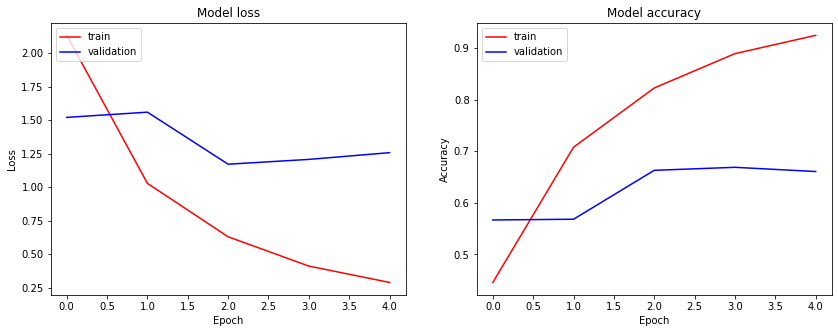

In [44]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_aug['loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_aug['accuracy'], 'r')
plt.plot(history_resnet50_aug['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

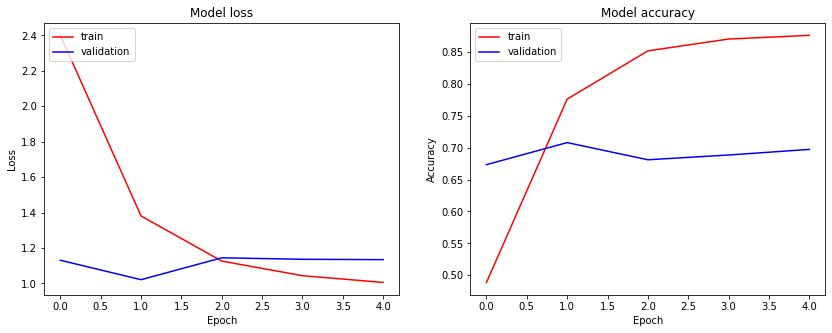

In [41]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_cutmix['loss'], 'r')
plt.plot(history_resnet50_cutmix['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_cutmix['accuracy'], 'r')
plt.plot(history_resnet50_cutmix['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

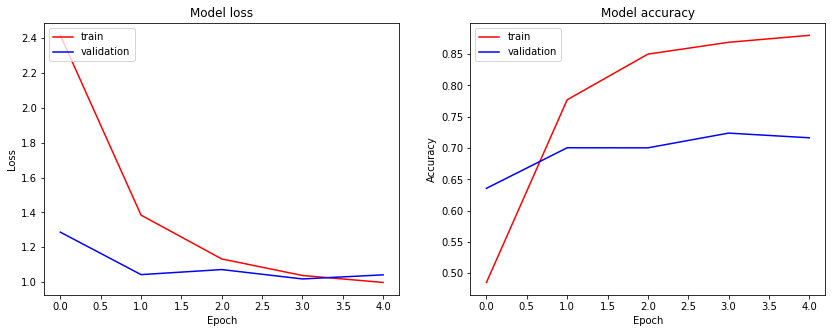

In [42]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_mixup['loss'], 'r')
plt.plot(history_resnet50_mixup['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_mixup['accuracy'], 'r')
plt.plot(history_resnet50_mixup['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### epoch = 50, learning rate = 0.001

In [40]:
EPOCH = 50

In [28]:
checkpoint_basic = tf.keras.callbacks.ModelCheckpoint("history/resnet50.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [29]:
checkpoint_aug = tf.keras.callbacks.ModelCheckpoint("history/resnet50_aug.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [41]:
checkpoint_cutmix = tf.keras.callbacks.ModelCheckpoint("history/resnet50_cutmix.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [42]:
checkpoint_mixup = tf.keras.callbacks.ModelCheckpoint("history/resnet50_mixup.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [33]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet50_2 = resnet50.fit(
    ds_train_classic,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_basic]
)

Epoch 1/50
750/750 [==============================] - 167s 207ms/step - loss: 4.4564 - accuracy: 0.0780 - val_loss: 4.6899 - val_accuracy: 0.0436

Epoch 00001: val_loss improved from inf to 4.68988, saving model to history/resnet50.keras
Epoch 2/50
750/750 [==============================] - 155s 206ms/step - loss: 2.9342 - accuracy: 0.3706 - val_loss: 2.2356 - val_accuracy: 0.4750

Epoch 00002: val_loss improved from 4.68988 to 2.23561, saving model to history/resnet50.keras
Epoch 3/50
750/750 [==============================] - 155s 206ms/step - loss: 2.0091 - accuracy: 0.5592 - val_loss: 1.6501 - val_accuracy: 0.5792

Epoch 00003: val_loss improved from 2.23561 to 1.65007, saving model to history/resnet50.keras
Epoch 4/50
750/750 [==============================] - 155s 206ms/step - loss: 1.5025 - accuracy: 0.6565 - val_loss: 1.3656 - val_accuracy: 0.6348

Epoch 00004: val_loss improved from 1.65007 to 1.36561, saving model to history/resnet50.keras
Epoch 5/50
750/750 [================

In [34]:
with open('history/history_resnet50_2.json', 'w') as f:
    pd.DataFrame(history_resnet50_2.history).to_json(f)

In [35]:
del resnet50

In [53]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet50_aug_2 = aug_resnet50.fit(
    ds_train_augmentation,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_aug]
)

Epoch 1/50
1500/1500 [==============================] - 273s 170ms/step - loss: 4.0545 - accuracy: 0.1326 - val_loss: 2.5907 - val_accuracy: 0.4095

Epoch 00001: val_loss improved from 4.65443 to 2.59073, saving model to history/resnet50_aug.keras
Epoch 2/50
1500/1500 [==============================] - 246s 164ms/step - loss: 2.4667 - accuracy: 0.4252 - val_loss: 1.6913 - val_accuracy: 0.5848

Epoch 00002: val_loss improved from 2.59073 to 1.69131, saving model to history/resnet50_aug.keras
Epoch 3/50
1500/1500 [==============================] - 247s 165ms/step - loss: 1.8233 - accuracy: 0.5508 - val_loss: 1.3847 - val_accuracy: 0.6458

Epoch 00003: val_loss improved from 1.69131 to 1.38467, saving model to history/resnet50_aug.keras
Epoch 4/50
1500/1500 [==============================] - 250s 167ms/step - loss: 1.4863 - accuracy: 0.6252 - val_loss: 1.2531 - val_accuracy: 0.6728

Epoch 00004: val_loss improved from 1.38467 to 1.25307, saving model to history/resnet50_aug.keras
Epoch 5/

In [54]:
with open('history/history_resnet50_aug_2.json', 'w') as f:
    pd.DataFrame(history_resnet50_aug_2.history).to_json(f)

In [55]:
del aug_resnet50

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet50_cutmix_2 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_cutmix]
)

Epoch 1/50
1500/1500 [==============================] - 323s 203ms/step - loss: 4.1533 - accuracy: 0.1477 - val_loss: 2.4332 - val_accuracy: 0.4374

Epoch 00001: val_loss improved from inf to 2.43322, saving model to history/resnet50_cutmix.keras
Epoch 2/50
1500/1500 [==============================] - 288s 192ms/step - loss: 2.7558 - accuracy: 0.4432 - val_loss: 1.5191 - val_accuracy: 0.6079

Epoch 00002: val_loss improved from 2.43322 to 1.51905, saving model to history/resnet50_cutmix.keras
Epoch 3/50
1500/1500 [==============================] - 288s 192ms/step - loss: 2.2097 - accuracy: 0.5693 - val_loss: 1.2356 - val_accuracy: 0.6623

Epoch 00003: val_loss improved from 1.51905 to 1.23559, saving model to history/resnet50_cutmix.keras
Epoch 4/50
1500/1500 [==============================] - 289s 193ms/step - loss: 1.9141 - accuracy: 0.6524 - val_loss: 1.1095 - val_accuracy: 0.6892

Epoch 00004: val_loss improved from 1.23559 to 1.10947, saving model to history/resnet50_cutmix.keras


In [ ]:
with open('history/history_resnet50_cutmix_2.json', 'w') as f:
    pd.DataFrame(history_resnet50_cutmix_2.history).to_json(f)

In [ ]:
del cutmix_resnet50

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet50_mixup_2 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(2*ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_mixup]
)

In [ ]:
with open('history/history_resnet50_mixup_2.json', 'w') as f:
    pd.DataFrame(history_resnet50_mixup_2.history).to_json(f)

In [ ]:
del resnet50_cutmix

In [2]:
import json
import matplotlib.pyplot as plt

In [5]:
with open('history/history_resnet50_2.json', 'r') as f:
    history_resnet50_2 = json.load(f)

In [6]:
with open('history/history_resnet50_aug_2.json', 'r') as f:
    history_resnet50_aug_2 = json.load(f)

In [9]:
history_resnet50_2 = history_conv(history_resnet50_2)
history_resnet50_aug_2 = history_conv(history_resnet50_aug_2)

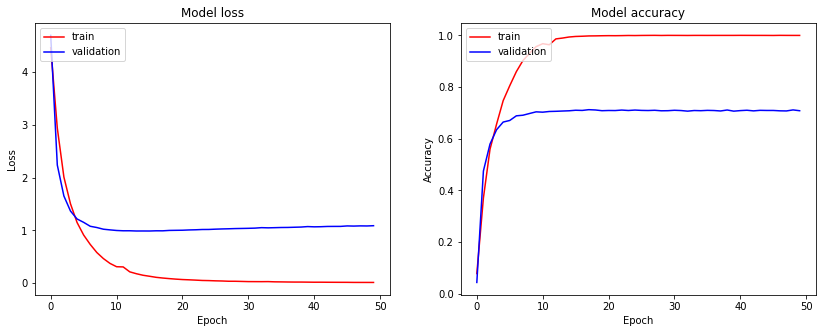

In [10]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_2['loss'], 'r')
plt.plot(history_resnet50_2['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_2['accuracy'], 'r')
plt.plot(history_resnet50_2['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

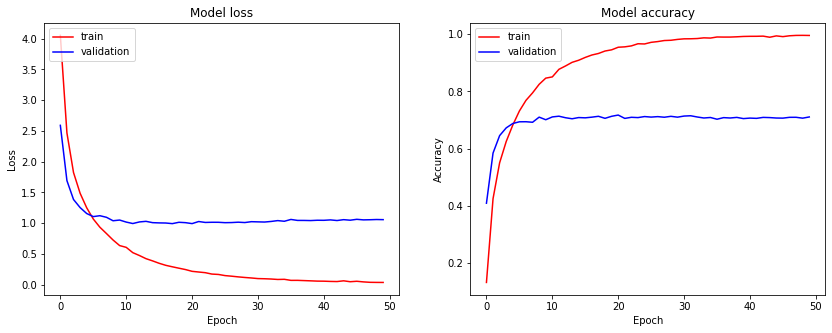

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_aug_2['loss'], 'r')
plt.plot(history_resnet50_aug_2['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_aug_2['accuracy'], 'r')
plt.plot(history_resnet50_aug_2['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 회고

### 진행 사항
    - nol, aug, cutmix, mixup 데이터셋을 제작하였음
    - 각 데이터 셋 별로 모델을 학습하고 결과를 확인하였음
    - 각 데이터 셋 별로 Overfitting 경향을 확인하였음
    
### 진행 예정 사항
    - 50 epoch에서의 학습을 계속 수행할 예정
    - 100 epoch에서의 학습을 계속 수행할 예정 (조별 학습)
        - 김서영님 : classic
        - 김용석님 : cutmix
        - 본    인 : mixup
    
    - 100 epoch 학습을 수행한 모델을 이용하여, 외부 test 데이터 셋으로 모델 성능 검증을 수행할 예정
        - 동일 폴더의 'make_test_data.ipynb' 파일로 데이터 셋 생성
    
### 확인된 사항
    - classic 보다 처리를 한 데이터들이 더 좁은 train-val acc 간극을 만들어냄
        - classic 25.76% 
        - augment 26.42%
        - cutmix  17.89%
        - mixup   16.38%